# Coherent dark states and polarization switching
Studying the effect of polarization switching on coherent dark states in a 9-level system. The system is made of two ground states with J = 1 and one excited state with J = 2 for a total of 11 levels. Basically just 9-level system studied in "Coherent dark states and polarization switching.ipynb" but with excited state having J = 2 so there are no polarization dark states. Note that the system actually has two polarization dark states which significantly complicates things.

## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import scipy
import qutip
from sympy import Symbol

from toy_systems.couplings import FirstRankCouplingJ, ToyEnergy
from toy_systems.dark_states import get_dark_states
from toy_systems.decays import CouplingDecay, ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.operators import JRotation
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, JQuantumNumbers, ToyQuantumNumbers
from toy_systems.utils import generate_P_op

## Set up states and basis
We start by defining the three states of the system: the ground states $|g0\rangle$ and $|g1\rangle$, and the excited state $|e\rangle$>

In [2]:
g0s = [BasisState(qn=JQuantumNumbers(label="g0", J = 1, mJ = mJ)) for mJ in np.arange(-1,2)]
g1s = [BasisState(qn=JQuantumNumbers(label="g1", J = 1, mJ = mJ)) for mJ in np.arange(-1,2)]
es = [BasisState(qn=JQuantumNumbers(label="e", J = 2, mJ = mJ)) for mJ in np.arange(-2,3)]

# Define basis
basis = Basis(g0s+g1s+es)
basis.print()

|0> = JQuantumNumbers(J=1, mJ=-1, label='g0')
|1> = JQuantumNumbers(J=1, mJ=0, label='g0')
|2> = JQuantumNumbers(J=1, mJ=1, label='g0')
|3> = JQuantumNumbers(J=1, mJ=-1, label='g1')
|4> = JQuantumNumbers(J=1, mJ=0, label='g1')
|5> = JQuantumNumbers(J=1, mJ=1, label='g1')
|6> = JQuantumNumbers(J=2, mJ=-2, label='e')
|7> = JQuantumNumbers(J=2, mJ=-1, label='e')
|8> = JQuantumNumbers(J=2, mJ=0, label='e')
|9> = JQuantumNumbers(J=2, mJ=1, label='e')
|10> = JQuantumNumbers(J=2, mJ=2, label='e')


## Define energies, couplings, decays and quantum system
I'm going to define the system in the rotating frame as usual.

### Energies

In [3]:
δ = Symbol('delta') # Energy splitting between |g0> and |g1
Δ = Symbol('Delta') # Detuning of drive field from 0
E0 = ToyEnergy(g0s, -δ/2)
E1 = ToyEnergy(g1s, +δ/2)
Ee = ToyEnergy(es, Δ)

### Couplings
Will treat the problem as if it has two time dependent laser fields: one polarized along z and the other one along x. The polarization will rotate back and forth between the two directions

In [4]:
Ωz = Symbol('Omega_z') # Drive field Rabi rate for z-polarization
Ωx = Symbol('Omega_x') # Drive field Rabi rate for x-polarization

# A condition to make sure the ground states don't get coupled to each other
def both_not_ground(state1, state2):
    return (state1.qn.label == 'e') or (state2.qn.label == 'e')

def both_not_excited(state1, state2):
    return not ((state1.qn.label == 'e') and (state2.qn.label == 'e'))

# Strings for time-dependence
time_dep_z = "(1-tanh(t/tau))/2"
time_dep_x = "(1+tanh(t/tau))/2"

coupling_z = FirstRankCouplingJ(Ωz, p_car=np.array((0,0,1)), other_conds = [both_not_ground, both_not_excited], time_dep = time_dep_z, time_args={"tau":1})
coupling_x = FirstRankCouplingJ(Ωx, p_car=np.array((1,0,0)), other_conds = [both_not_ground, both_not_excited], time_dep = time_dep_x, time_args={"tau":1})

### Decays
Defining a decay from all $|e\rangle$ to all $|g0\rangle$ and $|g1\rangle$ as permitted by angular momentum:

In [5]:
# Define dipole couplings that connect excited state to ground states
decay_couplings = [
    FirstRankCouplingJ(1, p_car=np.array((1,0,0)), other_conds=[both_not_ground, both_not_excited]),
    FirstRankCouplingJ(1, p_car=np.array((0,1,0)), other_conds=[both_not_ground, both_not_excited]),
    FirstRankCouplingJ(1, p_car=np.array((0,0,1)), other_conds=[both_not_ground, both_not_excited]),
]

decays = [CouplingDecay(e, Symbol("Gamma"), decay_couplings) for e in es]

### Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [6]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E0, E1, Ee, coupling_z, coupling_x],
    decays=decays,
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Time evolution
No matter what state the system starts in, it should always end up in the dark state, from which it will slowly evolve out since the dark state is not an eigenstate of the Hamiltonian.

In [7]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'delta': 1, 'Delta': 1, 'tau': 1, 'Omega_z': 1, 'Omega_x': 1, 'Gamma': 1}


### Find bright and dark states
Determining the bright and dark states for the parameters that are used for time-evolution so can keep track of the population in the bright and dark states.

In [8]:
# Set the parameters for the system
args['delta'] = 0.05
args['Delta'] = 0
args['Omega_z'] = 1
args['Omega_x'] = 1
args['Gamma'] = 1



# Find the dark and bright states for each mJ and each polarization
bright_states_z = []
dark_states_z = []
pol_dark_states_z = []
bright_states_x = []
dark_states_x = []
pol_dark_states_x = []
bright_states_y = []
dark_states_y = []
pol_dark_states_y = []

for g0, g1, e in zip(g0s, g1s, es[1:-1]):
    test_coupling_z = FirstRankCouplingJ(Ωz, p_car=np.array((0,0,1)), other_conds = [both_not_ground, both_not_excited])

    # Find the bright and dark states for z-polarization
    bright_states, dark_states, pol_dark_states = get_dark_states([g0, g1], e, [test_coupling_z])
    bright_states_z += bright_states
    dark_states_z += dark_states
    pol_dark_states_z += pol_dark_states
    
# Find the dark and bright states for x- and y-polarization by rotating the basis
# X-polarized
rotation_x = JRotation(np.pi/2, np.array((0,1,0)))
for bs in bright_states_z:
    bright_states_x.append(bs.apply_operator(basis, rotation_x))

for ds in dark_states_z:
    dark_states_x.append(ds.apply_operator(basis, rotation_x))

for ds in pol_dark_states_z:
    pol_dark_states_x.append(ds.apply_operator(basis, rotation_x))

# Y-polarized
rotation_y = JRotation(np.pi/2, np.array((1,0,0)))
for bs in bright_states_z:
    bright_states_y.append(bs.apply_operator(basis, rotation_y))

for ds in dark_states_z:
    dark_states_y.append(ds.apply_operator(basis, rotation_y))

for ds in pol_dark_states_z:
    pol_dark_states_y.append(ds.apply_operator(basis, rotation_y))
    
# Print the bright and dark states for each polarization:
print("X-polarization:\n")
for i, state in enumerate(bright_states_x):
    print(f"\n|Bx{i}> = ")
    state.print_state()

for i, state in enumerate(dark_states_x):
    print(f"\n|Dx{i}> = ")
    state.print_state()

print("\n\nY-polarization:\n")
for i, state in enumerate(bright_states_y):
    print(f"\n|By{i}> = ")
    state.print_state()

for i, state in enumerate(dark_states_y):
    print(f"\n|Dy{i}> = ")
    state.print_state()
    
print("\n\nZ-polarization:\n")
for i, state in enumerate(bright_states_z):
    print(f"\n|Bz{i}> = ")
    state.print_state()

for i, state in enumerate(dark_states_z):
    print(f"\n|Dz{i}> = ")
    state.print_state()

X-polarization:


|Bx0> = 
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g0')
+0.5000+0.0000j x JQuantumNumbers(J=1, mJ=0, label='g0')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g0')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g1')
+0.5000+0.0000j x JQuantumNumbers(J=1, mJ=0, label='g1')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g1')

|Bx1> = 
-0.5000+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g0')
+0.5000+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g0')
-0.5000+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g1')
+0.5000+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g1')

|Bx2> = 
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g0')
-0.5000+0.0000j x JQuantumNumbers(J=1, mJ=0, label='g0')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g0')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=-1, label='g1')
-0.5000+0.0000j x JQuantumNumbers(J=1, mJ=0, label='g1')
-0.3536+0.0000j x JQuantumNumbers(J=1, mJ=1, label='g1')

|Dx0> = 
-0.3536+0.0000j x JQuantu

In [9]:
args['tau'] = 1e-5

# Generate a Qobj representing the initial state
# psi0 = (1*g0s[0]).qobj(basis)
psi0 = (1*dark_states_z[0]).qobj(basis)

# Operators for getting probability of being in each state as a function of time
P_g0 = generate_P_op(g0s, basis)
P_g1 = generate_P_op(g1s, basis)
P_e = generate_P_op(es, basis)
P_B_z = generate_P_op(bright_states_z, basis)
P_D_z = generate_P_op(dark_states_z, basis)
P_B_x = generate_P_op(bright_states_x, basis)
P_D_x = generate_P_op(dark_states_x, basis)
P_B_y = generate_P_op(bright_states_y, basis)
P_D_y = generate_P_op(dark_states_y, basis)

P_ops = [P_g0, P_g1, P_e, P_B_z, P_D_z, P_B_x, P_D_x, P_B_y, P_D_y]

# Times at which result is requested
times = np.linspace(-10,10,1001)/args["delta"]

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0, rhs_reuse=False)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, args = args, e_ops = P_ops, progress_bar=pb, options = options)

 Total run time:   0.75s*] Elapsed 0.75s / Remaining 00:00:00:00



Population in excited state at the end: 2.1e+00 %
Photons per unit time: 2.10e-02


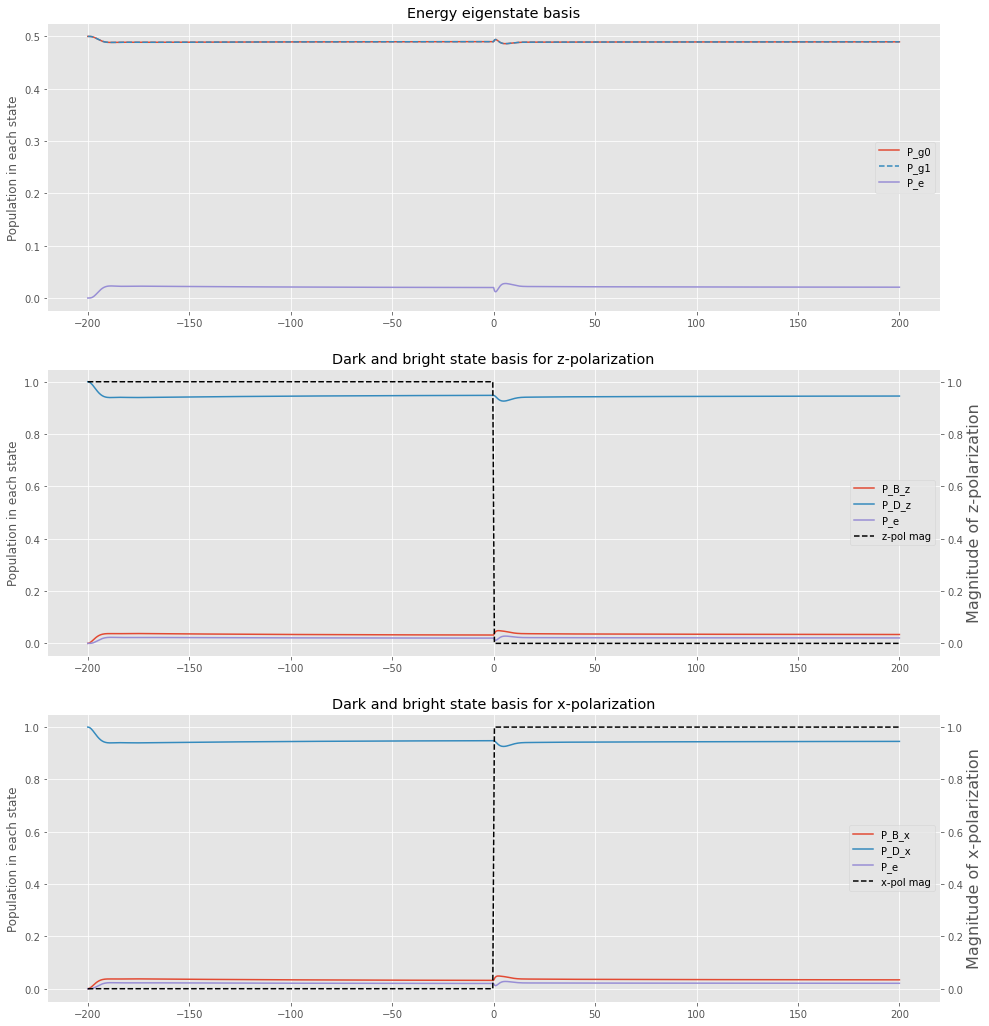

In [10]:
fig, ax = plt.subplots(3, 1, figsize = (16,18))
ax[0].plot(times, result.expect[0], label = "P_g0")
ax[0].plot(times, result.expect[1], label = "P_g1", ls = '--')
ax[0].plot(times, result.expect[2], label = "P_e")
ax[0].legend()
ax[0].set_ylabel("Population in each state")
ax[0].set_title("Energy eigenstate basis")

ln = []
ln +=ax[1].plot(times, result.expect[3], label = "P_B_z")
ln +=ax[1].plot(times, result.expect[4], label = "P_D_z")
ln +=ax[1].plot(times, result.expect[2], label = "P_e")
ax[1].set_ylabel("Population in each state")
ax[1].set_title("Dark and bright state basis for z-polarization")
ax1c = ax[1].twinx()
ax1c.grid(False)
ln +=coupling_z.plot_time_dep(times, args, ax = ax1c, c = 'k', ls = '--', label = "z-pol mag")
ax1c.set_ylabel("Magnitude of z-polarization")
ax[1].legend(ln, [l.get_label() for l in ln])


ln2 = []
ln2+=ax[2].plot(times, result.expect[5], label = "P_B_x")
ln2+=ax[2].plot(times, result.expect[6], label = "P_D_x")
ln2+=ax[2].plot(times, result.expect[2], label = "P_e")
ax[2].legend()
ax[2].set_ylabel("Population in each state")
ax[2].set_title("Dark and bright state basis for x-polarization")
ax2c = ax[2].twinx()
ax2c.grid(False)
ln2 +=coupling_x.plot_time_dep(times, args, ax = ax2c, c = 'k', ls = '--', label = "x-pol mag")
ax2c.set_ylabel("Magnitude of x-polarization")
ax[2].legend(ln2, [l.get_label() for l in ln2])

print(f"\nPopulation in excited state at the end: {result.expect[2][-1]*100:.1e} %")
print(f"Photons per unit time: {scipy.integrate.trapezoid(result.expect[2], x = times)/(times[-1]-times[0]):.2e}")

So what is happening here?:
- I'm starting the system in the z-polarization coherent dark state with mJ = -1.
- For x-polarization the initial state is also completely completely darl
- There is a small amount of population in the bright and excited state, with the amount depending on the value of $\delta$ (an probably also the other parameters to some extent)
- Not much changes when the polarization is flipped since the dark state for z-polarization is also dark for x-polarization
- The next question is: Can population be transferred to the bright state for x if the polarization switch is done with the right time dynamics?

## Trying different rise times

In [11]:
# Set the rise time
args["tau"] = 10

# Generate a Qobj representing the initial state
# psi0 = (1*g0s[0]).qobj(basis)
psi0 = (1*dark_states_z[0]).qobj(basis)

P_ops = [P_g0, P_g1, P_e, P_B_z, P_D_z, P_B_x, P_D_x, P_B_y, P_D_y]

# Times at which result is requested
times = np.linspace(-10,10,1001)/args["delta"]

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0, rhs_reuse=False)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, args = args, e_ops = P_ops, progress_bar=pb, options = options)

 Total run time:   0.75s*] Elapsed 0.75s / Remaining 00:00:00:00[*********55%*          ] Elapsed 0.42s / Remaining 00:00:00:00



Population in excited state at the end: 2.1e+00 %
Photons per unit time: 2.15e-02


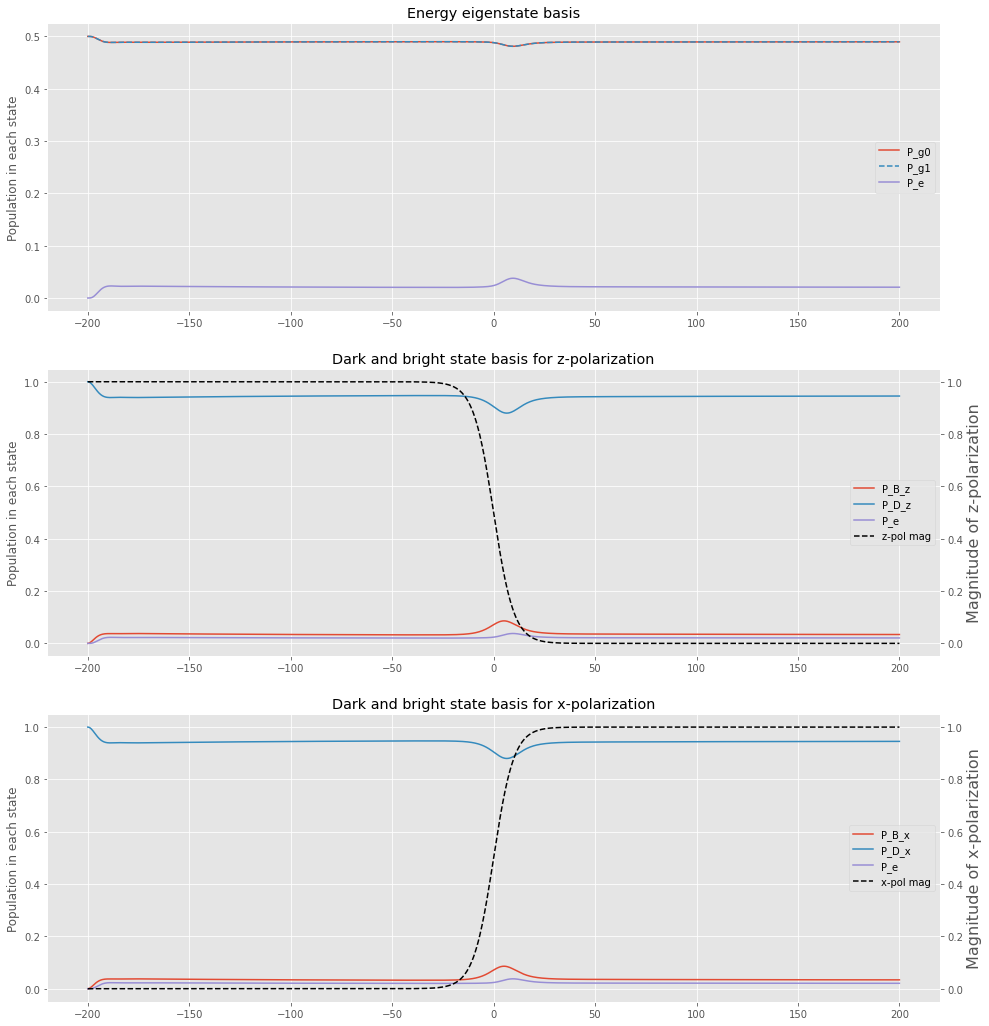

In [12]:
fig, ax = plt.subplots(3, 1, figsize = (16,18))
ax[0].plot(times, result.expect[0], label = "P_g0")
ax[0].plot(times, result.expect[1], label = "P_g1", ls = '--')
ax[0].plot(times, result.expect[2], label = "P_e")
ax[0].legend()
ax[0].set_ylabel("Population in each state")
ax[0].set_title("Energy eigenstate basis")

ln = []
ln +=ax[1].plot(times, result.expect[3], label = "P_B_z")
ln +=ax[1].plot(times, result.expect[4], label = "P_D_z")
ln +=ax[1].plot(times, result.expect[2], label = "P_e")
ax[1].set_ylabel("Population in each state")
ax[1].set_title("Dark and bright state basis for z-polarization")
ax1c = ax[1].twinx()
ax1c.grid(False)
ln +=coupling_z.plot_time_dep(times, args, ax = ax1c, c = 'k', ls = '--', label = "z-pol mag")
ax1c.set_ylabel("Magnitude of z-polarization")
ax[1].legend(ln, [l.get_label() for l in ln])


ln2 = []
ln2+=ax[2].plot(times, result.expect[5], label = "P_B_x")
ln2+=ax[2].plot(times, result.expect[6], label = "P_D_x")
ln2+=ax[2].plot(times, result.expect[2], label = "P_e")
ax[2].legend()
ax[2].set_ylabel("Population in each state")
ax[2].set_title("Dark and bright state basis for x-polarization")
ax2c = ax[2].twinx()
ax2c.grid(False)
ln2 +=coupling_x.plot_time_dep(times, args, ax = ax2c, c = 'k', ls = '--', label = "x-pol mag")
ax2c.set_ylabel("Magnitude of x-polarization")
ax[2].legend(ln2, [l.get_label() for l in ln2])

print(f"\nPopulation in excited state at the end: {result.expect[2][-1]*100:.1e} %")
print(f"Photons per unit time: {scipy.integrate.trapezoid(result.expect[2], x = times)/(times[-1]-times[0]):.2e}")

Takeaways:
- With just one switch, a slower switch seems to be better
- However, if we can do multiple switches (as we can) then shorter rise time might be better

## Continuous polarization switching


### Redefine couplings with periodic switching

In [13]:
# Strings for time-dependence
time_dep_z = "(1-tanh(asin(sin(2*pi*t/T))*T/tau))/2"
time_dep_x = "(1+tanh(asin(sin(2*pi*t/T))*T/tau))/2"

periodic_coupling_z = FirstRankCouplingJ(Ωz, p_car=np.array((0,0,1)), other_conds = [both_not_ground, both_not_excited], 
                                         time_dep = time_dep_z, time_args={"tau":1, "T":1})
periodic_coupling_x = FirstRankCouplingJ(Ωx, p_car=np.array((1,0,0)), other_conds = [both_not_ground, both_not_excited], 
                                         time_dep = time_dep_x, time_args={"tau":1, "T":1})

In [14]:
# Define dipole couplings that connect excited state to ground states
decay_couplings = [
    FirstRankCouplingJ(1, p_car=np.array((1,0,0)), other_conds=[both_not_ground, both_not_excited]),
    FirstRankCouplingJ(1, p_car=np.array((0,1,0)), other_conds=[both_not_ground, both_not_excited]),
    FirstRankCouplingJ(1, p_car=np.array((0,0,1)), other_conds=[both_not_ground, both_not_excited]),
]

decays = [CouplingDecay(e, Symbol("Gamma"), decay_couplings) for e in es]

### Define a QuantumSystem
The QuantumSystem object combines the basis, Hamiltonian and decays to make setting parameters for time evolution using QuTiP more convenient.

In [15]:
# Define the system
periodic_system = QuantumSystem(
    basis=basis,
    couplings=[E0, E1, Ee, periodic_coupling_z, periodic_coupling_x],
    decays=decays,
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj_periodic, c_qobj_periodic = periodic_system.get_qobjs()

### Time evolution


In [16]:
# Get a pointer to the time-evolution arguments
args = Hqobj_periodic.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'delta': 1, 'Delta': 1, 'tau': 1, 'T': 1, 'Omega_z': 1, 'Omega_x': 1, 'Gamma': 1}


In [17]:
args['delta'] = 0.05
args['Delta'] = 0
args['Omega_z'] = 1
args['Omega_x'] = 1
args['Gamma'] = 1
args['tau'] = 0.1
args['T'] = 10

# Generate a Qobj representing the initial state
# psi0 = (1*g0s[0]).qobj(basis)
psi0 = (1*dark_states_z[0]).qobj(basis)

P_ops = [P_g0, P_g1, P_e, P_B_z, P_D_z, P_B_x, P_D_x, P_B_y, P_D_y]

# Times at which result is requested
times = np.linspace(-10,10,1001)/args["delta"]

# Setting the max_step is sometimes necessary
options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0, rhs_reuse=False)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj_periodic, psi0, times, c_ops = c_qobj_periodic, args = args, e_ops = P_ops, progress_bar=pb, options = options)

 Total run time:   0.95s*] Elapsed 0.95s / Remaining 00:00:00:00



Population in excited state at the end: 3.6e+00 %
Photons per unit time: 2.96e-02


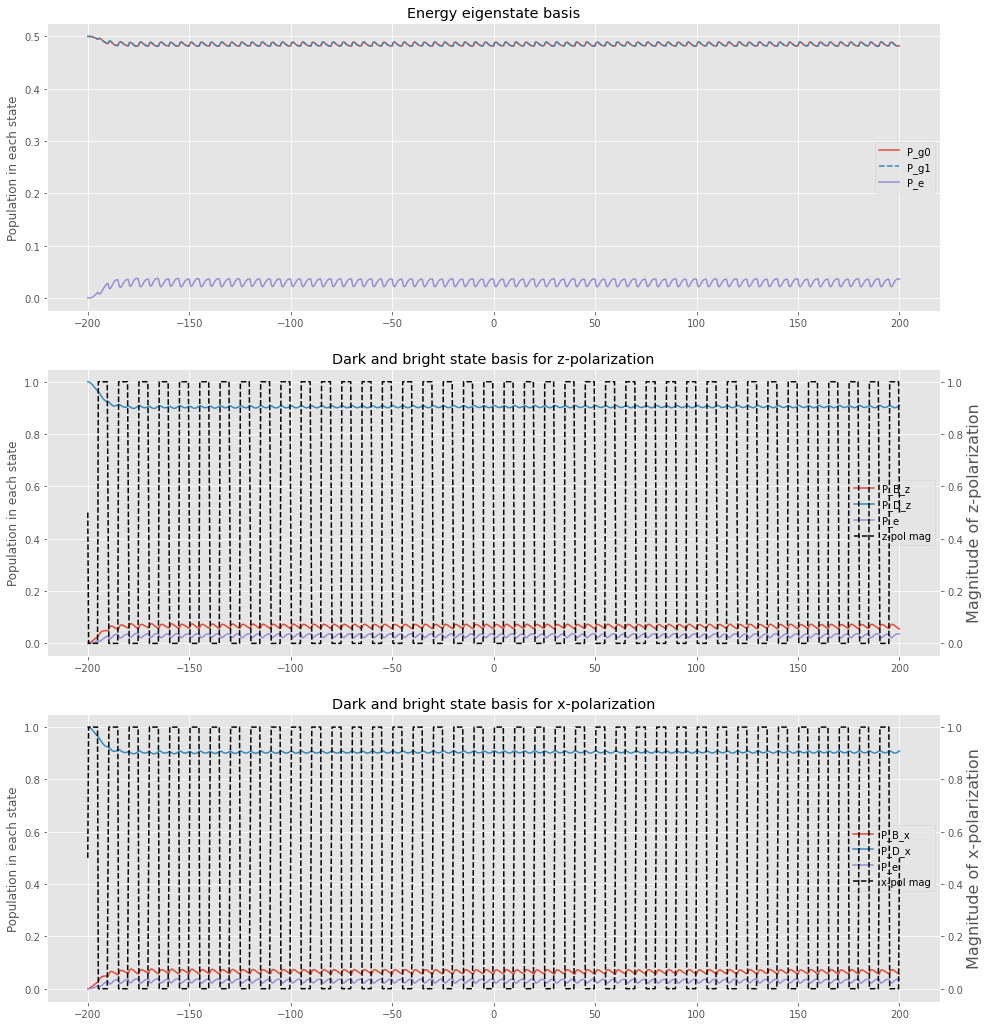

In [18]:
fig, ax = plt.subplots(3, 1, figsize = (16,18))
ax[0].plot(times, result.expect[0], label = "P_g0")
ax[0].plot(times, result.expect[1], label = "P_g1", ls = '--')
ax[0].plot(times, result.expect[2], label = "P_e")
ax[0].legend()
ax[0].set_ylabel("Population in each state")
ax[0].set_title("Energy eigenstate basis")

ln = []
ln +=ax[1].plot(times, result.expect[3], label = "P_B_z")
ln +=ax[1].plot(times, result.expect[4], label = "P_D_z")
ln +=ax[1].plot(times, result.expect[2], label = "P_e")
ax[1].set_ylabel("Population in each state")
ax[1].set_title("Dark and bright state basis for z-polarization")
ax1c = ax[1].twinx()
ax1c.grid(False)
ln +=periodic_coupling_z.plot_time_dep(times, args, ax = ax1c, c = 'k', ls = '--', label = "z-pol mag")
ax1c.set_ylabel("Magnitude of z-polarization")
ax[1].legend(ln, [l.get_label() for l in ln])


ln2 = []
ln2+=ax[2].plot(times, result.expect[5], label = "P_B_x")
ln2+=ax[2].plot(times, result.expect[6], label = "P_D_x")
ln2+=ax[2].plot(times, result.expect[2], label = "P_e")
ax[2].legend()
ax[2].set_ylabel("Population in each state")
ax[2].set_title("Dark and bright state basis for x-polarization")
ax2c = ax[2].twinx()
ax2c.grid(False)
ln2 +=periodic_coupling_x.plot_time_dep(times, args, ax = ax2c, c = 'k', ls = '--', label = "x-pol mag")
ax2c.set_ylabel("Magnitude of x-polarization")
ax[2].legend(ln2, [l.get_label() for l in ln2])

print(f"\nPopulation in excited state at the end: {result.expect[2][-1]*100:.1e} %")
print(f"Photons per unit time: {scipy.integrate.trapezoid(result.expect[2], x = times)/(times[-1]-times[0]):.2e}")

### Parameter scan
Is there some value of polarization switching frequency or rise time that works better than others?

In [19]:
default_args = {}
default_args['delta'] = 0.05
default_args['Delta'] = 0
default_args['Omega_z'] = 1
default_args['Omega_x'] = 1
default_args['Gamma'] = 1
default_args['tau'] = 0.1
default_args['T'] = 10

# Define function that will be executed in parallel
def parallel_func(args):
    # Generate a Qobj representing the initial state
    # psi0 = (1*g0s[0]).qobj(basis)
    psi0 = (1*dark_states_z[0]).qobj(basis)

    P_ops = [P_g0, P_g1, P_e, P_B_z, P_D_z, P_B_x, P_D_x, P_B_y, P_D_y]

    # Times at which result is requested
    times = np.linspace(-10,10,1001)/args["delta"]

    # Setting the max_step is sometimes necessary
    options = qutip.solver.Options(method = 'adams', nsteps=10000, max_step=1e0, rhs_reuse=True)

    # Setup a progress bar
    pb = qutip.ui.progressbar.EnhancedTextProgressBar()

    # Run the time-evolution
    result = qutip.mesolve(Hqobj_periodic, psi0, times, c_ops = c_qobj_periodic, args = args, e_ops = P_ops, 
                           progress_bar=pb, options = options)

    # Calculate rate at which photons are emitted
    rate = scipy.integrate.trapezoid(result.expect[2], x = times)/(times[-1]-times[0])
    
    return rate

#### Switching frequency

In [20]:
# Define values period to use
Ts = np.linspace(0.01, 10, 100)

# Generate list of arguments to pass to time evaluaation
args_list = [default_args.copy() | {'T': T} for T in Ts]

rates = np.array(joblib.Parallel(n_jobs = 10, backend='loky', verbose=True)(joblib.delayed(parallel_func)(args) for args in args_list))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   25.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   46.3s finished


Text(0, 0.5, 'Photon emission rate')

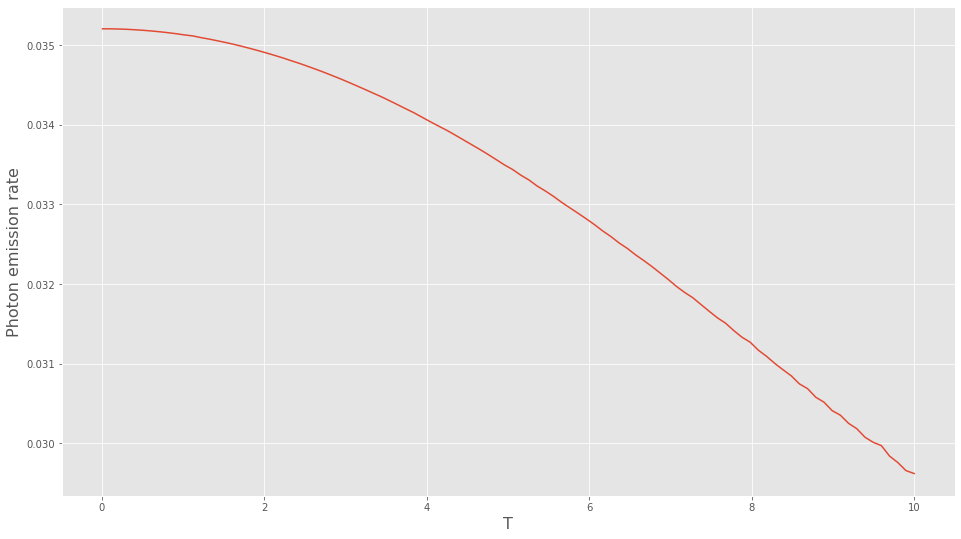

In [22]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(Ts, rates)
ax.set_xlabel("T", fontsize = 16)
ax.set_ylabel("Photon emission rate", fontsize = 16)

So the faster the switching the better apparently

#### Rise time

In [21]:
# Define values period to use
taus = np.linspace(0.01, 10, 100)

# Generate list of arguments to pass to time evaluaation
args_list = [default_args.copy() | {'tau': tau} for tau in taus]

rates = np.array(joblib.Parallel(n_jobs = 10, backend='loky', verbose=True)(joblib.delayed(parallel_func)(args) for args in args_list))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   10.0s finished


Text(0, 0.5, 'Photon emission rate')

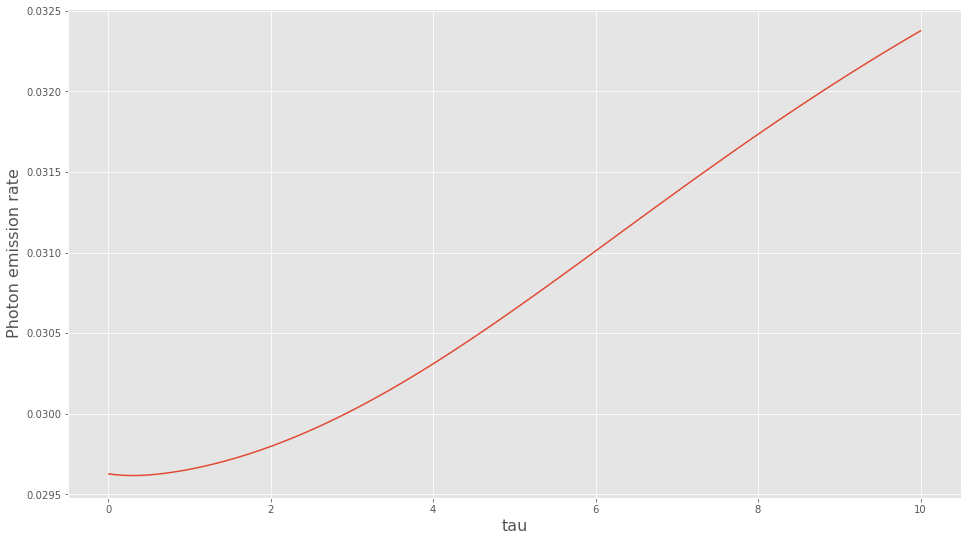

In [22]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(taus, rates)
ax.set_xlabel("tau", fontsize = 16)
ax.set_ylabel("Photon emission rate", fontsize = 16)